In [117]:
# Imports
import numpy as np
import torch
import tensorflow as tf
import tensorflow_datasets as tfdf
from tensorflow.keras import layers
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

# 1. PixelCNN Model

## 1.1 : Dataset Loading

In [118]:
# Load MNIST dataset
train_dataset, test_dataset = tfdf.load('mnist', split=['test', 'test'], 
                                shuffle_files=True, as_supervised=True)

In [119]:
# Function to convert image to black & white image 
def convert_black_white(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.math.round(image/255.)
    return image, tf.cast(image, tf.int32)

# Convert both train dataset and test dataset into black and white (0, 1) values
train_dataset = train_dataset.map(convert_black_white)
test_dataset = test_dataset.map(convert_black_white)

In [120]:
# cache dataset into memory
train_dataset = train_dataset.cache().batch(64)
test_dataset = test_dataset.batch(64).cache().prefetch(64)

## 1.2 : Model

In [121]:
# Global variables
image_width = 28
image_height = 28
image_channels = 1

1. First of all, we create Masked Convolution layer class for PixelCNN.

In [122]:
# Masked convolution layer class
class MaskedConvolutionLayer(layers.Layer):

    def __init__(self, mask_type, kernel_size=5, filters=1):
        super(MaskedConvolutionLayer, self).__init__()
        self.mask_type = mask_type
        self.kernel_size = kernel_size
        self.filters = filters
        
    def build(self, input_shape):
        self.layer_weights = self.add_weight(shape=[self.kernel_size, self.kernel_size, input_shape[-1], 
                                              self.filters], initializer='glorot_normal', trainable=True)
        self.layer_bias = self.add_weight(shape=(self.filters,), initializer='zeros', trainable=True)

        # Convolution mask
        # Create matrix of kernel_size * kernel_size of all ones
        mask_size = pow(self.kernel_size, 2)
        mask = np.ones(mask_size, dtype=np.float32)

        # Set all the pixels after center to 0 (Masking)
        center_pixel = mask_size // 2
        mask[center_pixel + 1:] = 0

        # Update mask based if type is A (set the center pixel to zero)
        if self.mask_type == 'A':
            mask[center_pixel] = 0
         
        mask = mask.reshape((self.kernel_size, self.kernel_size, 1, 1))
        self.mask = tf.constant(mask, dtype='float32')
        
    def call(self, inputs):
        # Mask weights convolution 
        masked_weights = tf.math.multiply(self.layer_weights, self.mask)

        # Apply convolution on input
        output = tf.nn.conv2d(inputs, masked_weights, 1, "SAME") + self.layer_bias
        
        # Get layer activation
        act_output = tf.nn.relu(output)
        return act_output

2. Now, we create class for the Residual Block of PixelCNN.

In [123]:
# Residual Block layer class
class ResidualBlock(layers.Layer):
    def __init__(self, h=32):
        super(ResidualBlock, self).__init__()

        # Residual layer consist of three masked convolution layers of type B masks
        self.forward = Sequential([MaskedConvolutionLayer('B', kernel_size=1, filters=h),
                                   MaskedConvolutionLayer('B', kernel_size=3, filters=h),
                                   MaskedConvolutionLayer('B', kernel_size=1, filters=2*h)])         
    def call(self, inputs):
        # Apply convolutions
        x = self.forward(inputs)

        # Apply residuals
        x = x + inputs
        return x

3. Now we create PixelCNN class consisting of both Convolution and Residual layers.

In [124]:
def PixelCnn(hidden_features=64, output_features=64, resblocks_num=5):
    # Initiate input tensor 
    inputs = layers.Input(shape=[image_width, image_height, image_channels])

    # Apply masked convolution on the input
    outputs = MaskedConvolutionLayer('A', kernel_size=7, filters=2*hidden_features)(inputs)

    # Apply number of residual block on the outputs
    for _ in range(resblocks_num):
        outputs = ResidualBlock(hidden_features)(outputs)
        
    # Apply Convolution with relu activation
    outputs = layers.Conv2D(output_features, (1, 1), padding='same', activation='relu')(outputs) 

    # Apply Convolution with sigmoid activation
    outputs = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(outputs)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name='PixelCnn')

In [125]:
# Create Pixel class model instance
pixelCNNModel = PixelCnn()
pixelCNNModel.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    metrics=[tf.keras.losses.BinaryCrossentropy()])

In [127]:
pixelCNNModel.fit(train_dataset, epochs = 5, validation_data=test_dataset)

Epoch 1/5
157/157 [==============================] - 571s 4s/step - loss: 0.1250 - binary_crossentropy: 0.1248 - val_loss: 0.1013 - val_binary_crossentropy: 0.1012
Epoch 2/5
157/157 [==============================] - 583s 4s/step - loss: 0.1018 - binary_crossentropy: 0.1018 - val_loss: 0.0968 - val_binary_crossentropy: 0.0968
Epoch 3/5
157/157 [==============================] - 610s 4s/step - loss: 0.0975 - binary_crossentropy: 0.0975 - val_loss: 0.0974 - val_binary_crossentropy: 0.0974
Epoch 4/5
157/157 [==============================] - 512s 3s/step - loss: 0.0945 - binary_crossentropy: 0.0945 - val_loss: 0.0935 - val_binary_crossentropy: 0.0935
Epoch 5/5
157/157 [==============================] - 512s 3s/step - loss: 0.0927 - binary_crossentropy: 0.0927 - val_loss: 0.0908 - val_binary_crossentropy: 0.0907


# 2. Parallel and Flexible Sampling Algorithm

1. Here, we will implement the algorithm preseted in the paper for Parallel and Flexible sampling.

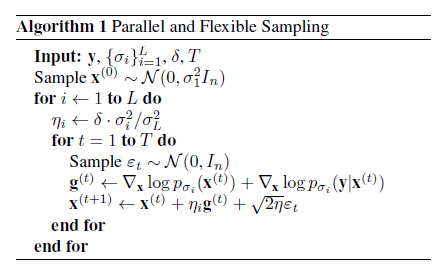

In [130]:
# Function to sample from autoregressive generative models
# y - label for conditional generation
# lstSigma - List of different noise levels
# delta - Learning rate
# T - number of samples

def pnfSampling(y, lstSigma, delta, T):

    # List to store samples
    x = torch.Tensor(T+1, 1, image_channels, image_height, image_width)

    # First sample is randomly generated from a normal distribution
    x[0] = torch.randn(1, image_channels, image_height, image_width)

    # Total number of noise levels
    L = len(lstSigma)

    # Lowest noise level
    sigma_l = lstSigma[0]

    for i in range(L):
        # Current noise level
        sigma_i = lstSigma[i]

        # learning rate coefficient with noise level applied
        eta_i = delta * pow(sigma_i, 2) / pow(sigma_l, 2)

        for t in range(1, T):
            # Random noise sampled from normal distribution for Langevin dynamics
            noise_t = torch.rand_like(x[0])

            # Smoothed conditional density 
            g_t = get_smoothed_conditional_density_grad(x[0], sigma_i)

            # Next sample
            x[t+1] = x[t] + (eta_i * g_t) + (np.sqrt(pow(eta_i, 2)) * noise_t)
    return x

2. Here, we have defined a function to get gradient of log-density of this smoothed conditional density.

In [131]:
# Compute gradient of smoothed conditional log density
def get_smoothed_conditional_density_grad(x, sigma):
    x = x.detach()
    x.requires_grad = True
    sc_density = get_smoothed_conditional_density(x, sigma)
    sc_density_grad = torch.autograd.grad(-sc_density.sum(), x)[0]
    return sc_density

3. Here, we have defined a function to the log-density of this smoothed conditional density. The formula shown below is used to compute the log of smoothed conditional density

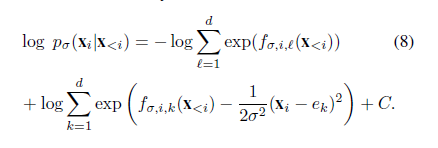

In [134]:
# Compute smoothed log density from discretized log density
def get_smoothed_conditional_density(x, sigma):
    #y = pixelCNNModel(x)
    # Here, we can update the PixelCNN model to get actual discretized log density
    disc_ld = torch.Tensor(1, 1, 28, 28)

    # Different levels of discretized density (Here we have two, as we have black and white images)
    disc_levels = torch.Tensor([-1, 1])
    disc_levels = disc_levels.view(2, 1, 1, 1, 1)

    # This line computes the first term of the above mentioned formula
    sc_density_1 = -torch.logsumexp(disc_ld, axis=0)

    # This line computes the second term of the above mentioned formula
    sc_density_2 = torch.logsumexp(disc_ld - (1 / (2 * pow(sigma, 2))) * pow((x - disc_levels), 2), axis=0)

    sc_density = sc_density_1 + sc_density_2
    return sc_density

4. Now we will apply Parallel and Flexible sampling algorithm

In [135]:
# Initiate noise levels
L = 10
lstSigma = np.linspace(0, 1, L+1)
lstSigma = lstSigma[1:]

# Initiate learning rate
delta = 0.001

# Initiate number of samples
T = 200

sc_density = pnfSampling(0, lstSigma, delta, T)